In [1]:
# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Checking available device (CPU/GPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Defining data transformations

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading dataset and Providing the path to the already separatef training, validation and testing sets

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root=r'/kaggle/input/wildfire-comp-6721/archive/train', transform=data_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root=r'/kaggle/input/wildfire-comp-6721/archive/valid', transform=data_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=r'/kaggle/input/wildfire-comp-6721/archive/test', transform=data_transforms)

# Generate a random sample of 10 images from the test dataset


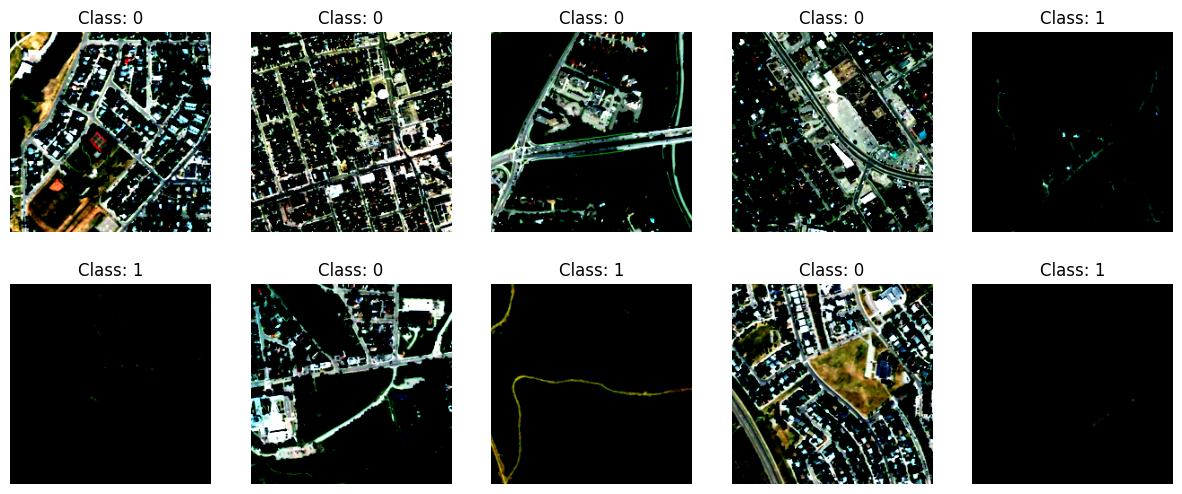

In [5]:
# Generate a random sample of 10 images from the test dataset
sample_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True)
sample_iter = iter(sample_loader)
sample_images, sample_labels = next(sample_iter)

# Display the sample images
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0))  # Transpose the tensor to (H, W, C) for display
    plt.title(f"Class: {sample_labels[i]}")
    plt.axis('off')
plt.show()


# Batch size and learning rate configurations


In [6]:
batch_size = 64
learning_rate = 0.001
num_epochs = 40

# Print the configuration
print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}, and epochs: {num_epochs}")


Training with batch size: 64, learning rate: 0.001, and epochs: 40


# Creating data loaders


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initializing AlexNet model


In [8]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Defining loss function and optimizer


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Lists to store loss and accuracy during training


In [10]:
loss_during_epoch = []
accuracy_during_epoch = []


# Training loop


In [11]:
patience = 5
best_valid_loss = float('inf')
epochs_no_improve = 0
early_stopping = False

train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        # Your existing training code...
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)


    # Validation
    model.eval()
    valid_loss = 0.0
    valid_correct_predictions = 0
    valid_total_predictions = 0

    with torch.no_grad():
        for valid_inputs, valid_labels in valid_loader:
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            valid_outputs = model(valid_inputs)
            valid_loss += criterion(valid_outputs, valid_labels).item()

            _, valid_predicted = torch.max(valid_outputs, 1)
            valid_correct_predictions += (valid_predicted == valid_labels).sum().item()
            valid_total_predictions += valid_labels.size(0)


    end_time = time.time()
    elapsed_time = end_time - start_time

    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct_predictions / valid_total_predictions

    # Append to lists
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_loss}, Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy * 100:.2f}%, "
          f"Running time: {elapsed_time}")

    # Early stopping logic
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            early_stopping = True
            break

# After the loop, you can check if early stopping occurred
if early_stopping:
    print("Training stopped due to early stopping.")
else:
    print("Training completed all epochs.")

Epoch 1, Loss: 0.1956439579050698, Accuracy: 92.78%, Validation Loss: 0.6345894785240443, Validation Accuracy: 80.49%, Running time: 147.15609788894653
Epoch 2, Loss: 0.14040555344325698, Accuracy: 95.00%, Validation Loss: 0.4383937596070646, Validation Accuracy: 85.73%, Running time: 104.59757804870605
Epoch 3, Loss: 0.10602304289217837, Accuracy: 96.26%, Validation Loss: 0.2852691039443016, Validation Accuracy: 91.90%, Running time: 105.67674350738525
Epoch 4, Loss: 0.10592778656676323, Accuracy: 96.34%, Validation Loss: 0.29926528909591715, Validation Accuracy: 88.65%, Running time: 103.61613988876343
Epoch 5, Loss: 0.08903765175380036, Accuracy: 96.91%, Validation Loss: 0.24986289178181176, Validation Accuracy: 91.00%, Running time: 104.69242715835571
Epoch 6, Loss: 0.07319960480522432, Accuracy: 97.61%, Validation Loss: 0.2822096170951622, Validation Accuracy: 91.14%, Running time: 104.23083806037903
Epoch 7, Loss: 0.0768400568370066, Accuracy: 97.25%, Validation Loss: 0.228239634

# Saving the model weights


In [12]:
torch.save(model.state_dict(), f'Wildfire_ResNet18_weights_batch_size_{batch_size}_lr_{learning_rate}_epochs_{num_epochs}.pth')


# Evaluation on test set


In [13]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


# Calculating evaluation metrics


In [14]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')
cm = confusion_matrix(y_true, y_pred)


# Printing evaluation metrics



In [15]:
print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Epochs: {num_epochs}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Batch Size: 64, Learning Rate: 0.001, Epochs: 40
Accuracy: 0.9542566709021602
Precision: 0.9542566709021602
Recall: 0.9542566709021602
F1 Score: 0.9542566709021602


# Plotting confusion matrix


Confusion Matrix:


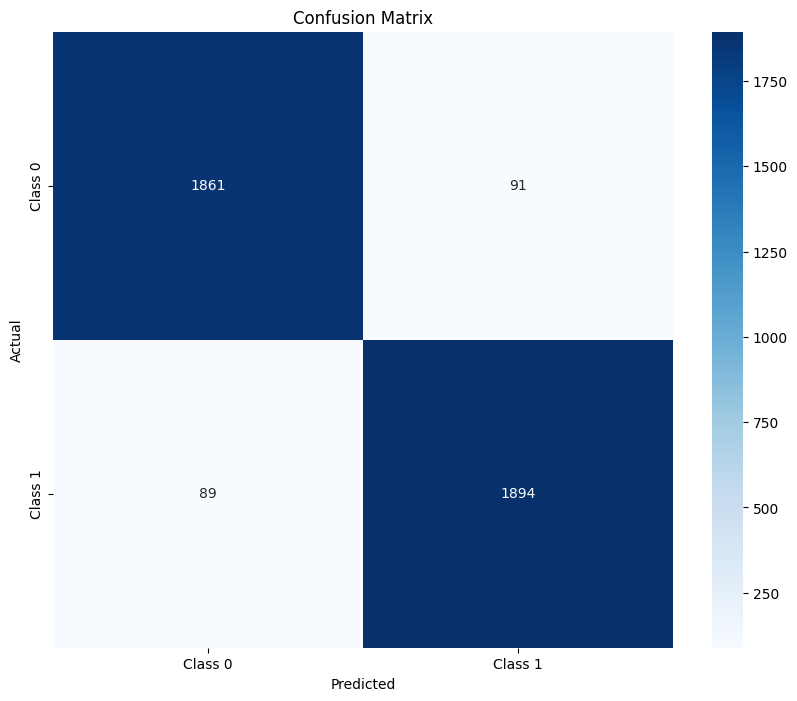

In [16]:
print("Confusion Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(len(cm))], yticklabels=[f'Class {i}' for i in range(len(cm))])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting accuracy and loss during training


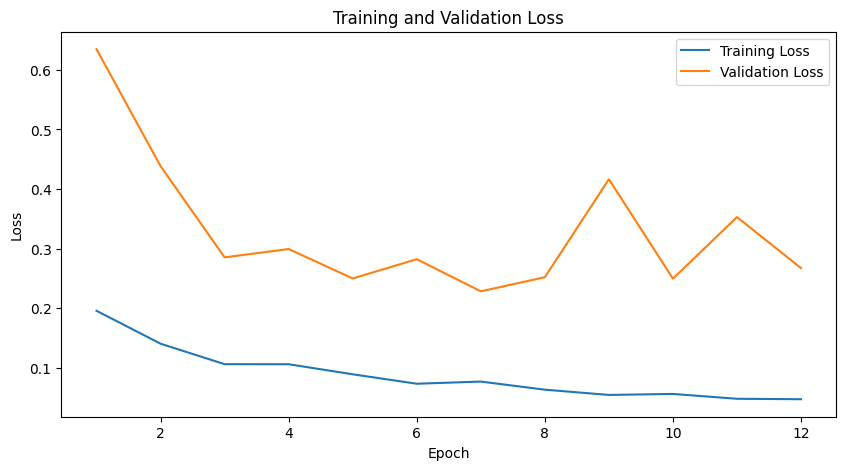

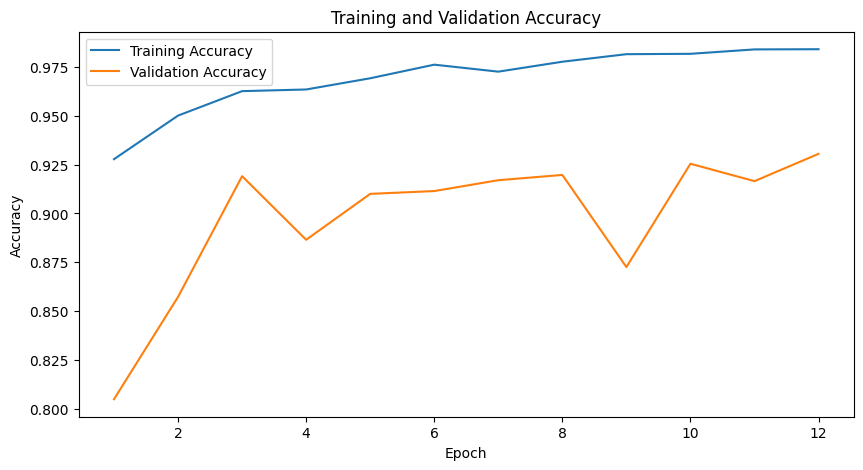

In [17]:
# Determine the minimum length between range and train_loss_list
min_length = min(len(range(1, 18 + 1)), len(train_loss_list))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, min_length + 1), train_loss_list[:min_length], label='Training Loss')
plt.plot(range(1, min_length + 1), valid_loss_list[:min_length], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Determine the minimum length between range and train_accuracy_list
min_length_acc = min(len(range(1, 18 + 1)), len(train_accuracy_list))

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, min_length_acc + 1), train_accuracy_list[:min_length_acc], label='Training Accuracy')
plt.plot(range(1, min_length_acc + 1), valid_accuracy_list[:min_length_acc], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3935 samples in 0.036s...
[t-SNE] Computed neighbors for 3935 samples in 8.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3935
[t-SNE] Computed conditional probabilities for sample 2000 / 3935
[t-SNE] Computed conditional probabilities for sample 3000 / 3935
[t-SNE] Computed conditional probabilities for sample 3935 / 3935
[t-SNE] Mean sigma: 20.227837
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.723465
[t-SNE] KL divergence after 2000 iterations: 1.833493


/tmp/ipykernel_34/3063265131.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names))


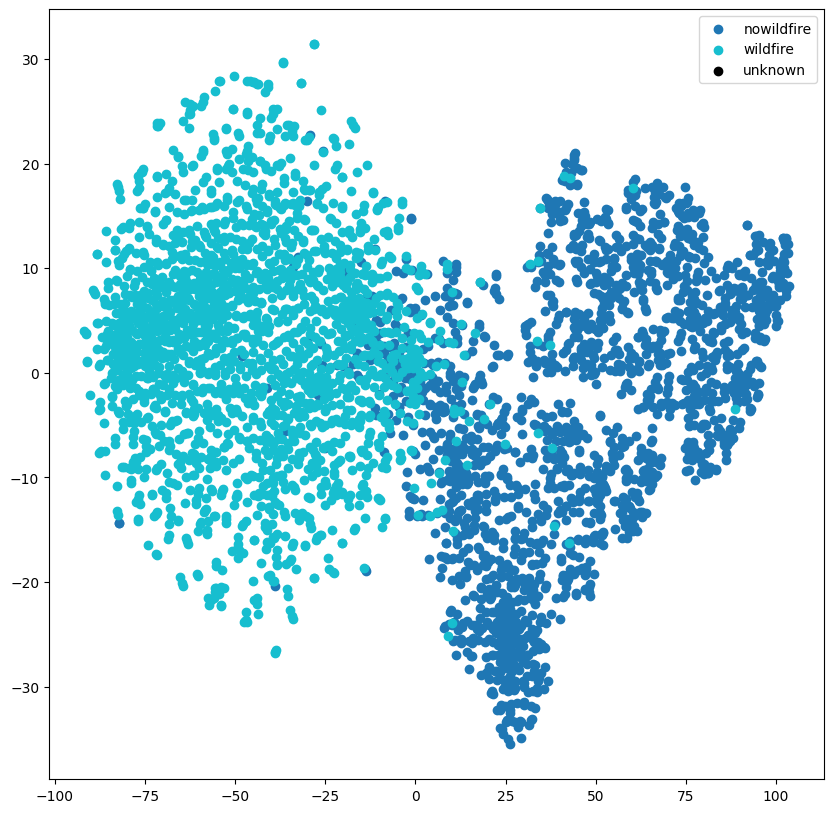

In [19]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.to(device)

model = torch.nn.Sequential(*(list(model.children())[:-1]))

model.eval()

features = []
labels = []
for images, target in test_loader:
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# reshape the features array to have two dimensions
n_samples = features.shape[0]
n_features = np.prod(features.shape[1:])
features = features.reshape((n_samples, n_features))

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names=list(train_dataset.class_to_idx.keys())

# Create a colormap with enough distinct colors for all classes
cmap = plt.cm.get_cmap('tab10', len(target_names))

u = False

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=[cmap(i)])
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()
